# 1. About the dataset:

Buying a house is a complex decision influenced by factors like location property size, proximity to amenities (offices, schools, hospitals), and most importantly, the price. In Bengaluru, housing prices are affected by factors such as the impact of demonetization, the Real Estate (Regulation and Development) Act (RERA), and mistrust in property developers. Studies show a wide range of options across price segments from ₹15-62 lakh INR, although property prices in Bengaluru dropped by approximately 5% in the second half of 2017. With its vibrant culture, favorable climate, and abundant job opportunities, determining property prices in Bengaluru remains challenging.

* Area_type - Description of the area
* Availability - When it can be possessed or when it is ready
* Location - Where it is located in Bengaluru
* Size - BHK or Bedrooms
* Society - To which society it belongs
* Total_sqft - Size of the property in sq.ft
* Bath - No. of Bathrooms
* Balcony - No. of the Balcony
* Price - Value of the property in lakhs (Indian Rupee - ₹)





# 2. Data Exploration and Preprocessing & Feature Engineering

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, BooleanType, FloatType
from pyspark.sql.functions import expr, mean, col, stddev, count, sum, udf
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, OneHotEncoder

Initializes a Spark session, loads the housing dataset, displays sample rows, and prints dataset dimensions.

In [ ]:
spark = SparkSession.builder.appName("HousePricePrediction").getOrCreate()

df = spark.read.csv("Bengaluru_House_Data.csv", header=True, inferSchema=True)
df.show(5)
print(f"Rows: {df.count()}, Columns: {len(df.columns)}")

+--------------------+-------------+--------------------+---------+-------+----------+----+-------+-----+
|           area_type| availability|            location|     size|society|total_sqft|bath|balcony|price|
+--------------------+-------------+--------------------+---------+-------+----------+----+-------+-----+
|Super built-up  Area|       19-Dec|Electronic City P...|    2 BHK|Coomee |      1056|   2|      1|39.07|
|          Plot  Area|Ready To Move|    Chikka Tirupathi|4 Bedroom|Theanmp|      2600|   5|      3|120.0|
|      Built-up  Area|Ready To Move|         Uttarahalli|    3 BHK|   NULL|      1440|   2|      3| 62.0|
|Super built-up  Area|Ready To Move|  Lingadheeranahalli|    3 BHK|Soiewre|      1521|   3|      1| 95.0|
|Super built-up  Area|Ready To Move|            Kothanur|    2 BHK|   NULL|      1200|   2|      1| 51.0|
+--------------------+-------------+--------------------+---------+-------+----------+----+-------+-----+
only showing top 5 rows

Rows: 13320, Columns:

Displays the schema of the dataset, provides summary statistics for numerical columns.

In [ ]:
df.printSchema()
df.describe().show()

root
 |-- area_type: string (nullable = true)
 |-- availability: string (nullable = true)
 |-- location: string (nullable = true)
 |-- size: string (nullable = true)
 |-- society: string (nullable = true)
 |-- total_sqft: string (nullable = true)
 |-- bath: integer (nullable = true)
 |-- balcony: integer (nullable = true)
 |-- price: double (nullable = true)

+-------+--------------------+-------------+----------+---------+-------+------------------+------------------+------------------+------------------+
|summary|           area_type| availability|  location|     size|society|        total_sqft|              bath|           balcony|             price|
+-------+--------------------+-------------+----------+---------+-------+------------------+------------------+------------------+------------------+
|  count|               13320|        13320|     13319|    13304|   7818|             13320|             13247|             12711|             13320|
|   mean|                NULL|        

Drop less important features

In [ ]:
df = df.drop("area_type", "society", "availability")
df.show()
print(f"Shape: Rows = {df.count()}, Columns = {len(df.columns)}")

+--------------------+---------+----------+----+-------+-----+
|            location|     size|total_sqft|bath|balcony|price|
+--------------------+---------+----------+----+-------+-----+
|Electronic City P...|    2 BHK|      1056|   2|      1|39.07|
|    Chikka Tirupathi|4 Bedroom|      2600|   5|      3|120.0|
|         Uttarahalli|    3 BHK|      1440|   2|      3| 62.0|
|  Lingadheeranahalli|    3 BHK|      1521|   3|      1| 95.0|
|            Kothanur|    2 BHK|      1200|   2|      1| 51.0|
|          Whitefield|    2 BHK|      1170|   2|      1| 38.0|
|    Old Airport Road|    4 BHK|      2732|   4|   NULL|204.0|
|        Rajaji Nagar|    4 BHK|      3300|   4|   NULL|600.0|
|        Marathahalli|    3 BHK|      1310|   3|      1|63.25|
|        Gandhi Bazar|6 Bedroom|      1020|   6|   NULL|370.0|
|          Whitefield|    3 BHK|      1800|   2|      2| 70.0|
|          Whitefield|4 Bedroom|      2785|   5|      3|295.0|
|  7th Phase JP Nagar|    2 BHK|      1000|   2|      1

Process null values

In [ ]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+--------+----+----------+----+-------+-----+
|location|size|total_sqft|bath|balcony|price|
+--------+----+----------+----+-------+-----+
|       1|  16|         0|  73|    609|    0|
+--------+----+----------+----+-------+-----+



In [ ]:
df = df.dropna()
df.show(5)
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()
print(f"Shape: Rows = {df.count()}, Columns = {len(df.columns)}")

+--------------------+---------+----------+----+-------+-----+
|            location|     size|total_sqft|bath|balcony|price|
+--------------------+---------+----------+----+-------+-----+
|Electronic City P...|    2 BHK|      1056|   2|      1|39.07|
|    Chikka Tirupathi|4 Bedroom|      2600|   5|      3|120.0|
|         Uttarahalli|    3 BHK|      1440|   2|      3| 62.0|
|  Lingadheeranahalli|    3 BHK|      1521|   3|      1| 95.0|
|            Kothanur|    2 BHK|      1200|   2|      1| 51.0|
+--------------------+---------+----------+----+-------+-----+
only showing top 5 rows

+--------+----+----------+----+-------+-----+
|location|size|total_sqft|bath|balcony|price|
+--------+----+----------+----+-------+-----+
|       0|   0|         0|   0|      0|    0|
+--------+----+----------+----+-------+-----+

Shape: Rows = 12710, Columns = 6


In [ ]:
df.select("size").distinct().show()

+----------+
|      size|
+----------+
|    14 BHK|
| 5 Bedroom|
|     7 BHK|
| 1 Bedroom|
| 9 Bedroom|
| 3 Bedroom|
|    27 BHK|
|      1 RK|
|10 Bedroom|
|    11 BHK|
|     4 BHK|
| 6 Bedroom|
|     2 BHK|
| 4 Bedroom|
| 2 Bedroom|
|     6 BHK|
|     8 BHK|
|    13 BHK|
| 8 Bedroom|
|     3 BHK|
+----------+
only showing top 20 rows



Add new feature BHK from splitting size column

In [ ]:
df = df.withColumn("BHK", expr("int(split(size, ' ')[0])"))
df.show()

+--------------------+---------+----------+----+-------+-----+---+
|            location|     size|total_sqft|bath|balcony|price|BHK|
+--------------------+---------+----------+----+-------+-----+---+
|Electronic City P...|    2 BHK|      1056|   2|      1|39.07|  2|
|    Chikka Tirupathi|4 Bedroom|      2600|   5|      3|120.0|  4|
|         Uttarahalli|    3 BHK|      1440|   2|      3| 62.0|  3|
|  Lingadheeranahalli|    3 BHK|      1521|   3|      1| 95.0|  3|
|            Kothanur|    2 BHK|      1200|   2|      1| 51.0|  2|
|          Whitefield|    2 BHK|      1170|   2|      1| 38.0|  2|
|        Marathahalli|    3 BHK|      1310|   3|      1|63.25|  3|
|          Whitefield|    3 BHK|      1800|   2|      2| 70.0|  3|
|          Whitefield|4 Bedroom|      2785|   5|      3|295.0|  4|
|  7th Phase JP Nagar|    2 BHK|      1000|   2|      1| 38.0|  2|
|           Gottigere|    2 BHK|      1100|   2|      2| 40.0|  2|
|            Sarjapur|3 Bedroom|      2250|   3|      2|148.0|

In [ ]:
df.select("total_sqft").distinct().show()

+-----------+
| total_sqft|
+-----------+
|       1436|
|       1090|
|        675|
|       1512|
|       3606|
|        296|
|        829|
|       1159|
|       2162|
|1160 - 1315|
|       3210|
|        691|
|       2088|
|        800|
|        451|
|       1372|
|        944|
|       2275|
|       1394|
|     3405.1|
+-----------+
only showing top 20 rows



Check data type of total_sqft feature

In [ ]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

is_float_udf = udf(is_float, BooleanType())
invalid_sqft = df.filter(~is_float_udf(col("total_sqft")))
invalid_sqft.show(10)

+--------------------+---------+--------------+----+-------+------+---+
|            location|     size|    total_sqft|bath|balcony| price|BHK|
+--------------------+---------+--------------+----+-------+------+---+
|           Yelahanka|    4 BHK|   2100 - 2850|   4|      0| 186.0|  4|
|              Hebbal|    4 BHK|   3067 - 8156|   4|      0| 477.0|  4|
|  8th Phase JP Nagar|    2 BHK|   1042 - 1105|   2|      0|54.005|  2|
|            Sarjapur|    2 BHK|   1145 - 1340|   2|      0| 43.49|  2|
|            KR Puram|    2 BHK|   1015 - 1540|   2|      0|  56.8|  2|
|             Kengeri|    1 BHK|34.46Sq. Meter|   1|      0|  18.5|  1|
|         Hennur Road|    2 BHK|   1195 - 1440|   2|      0| 63.77|  2|
|           Yelahanka|    2 BHK|   1120 - 1145|   2|      0| 48.13|  2|
|        Bettahalsoor|4 Bedroom|   3090 - 5002|   4|      0| 445.0|  4|
|Banashankari Stag...|    2 BHK|   1160 - 1195|   2|      0|59.935|  2|
+--------------------+---------+--------------+----+-------+----

Convert unusual format of data in total_sqft feature

In [ ]:
def convert_sqft(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

convert_sqft_udf = udf(convert_sqft, FloatType())
df = df.withColumn("total_sqft", convert_sqft_udf(col("total_sqft")))
df = df.filter(col("total_sqft").isNotNull())

Add new feature called price per square feet

In [ ]:
df = df.withColumn("price_per_sqft", (col("price") * 100000) / col("total_sqft"))
df.show()

+--------------------+---------+----------+----+-------+-----+---+------------------+
|            location|     size|total_sqft|bath|balcony|price|BHK|    price_per_sqft|
+--------------------+---------+----------+----+-------+-----+---+------------------+
|Electronic City P...|    2 BHK|    1056.0|   2|      1|39.07|  2| 3699.810606060606|
|    Chikka Tirupathi|4 Bedroom|    2600.0|   5|      3|120.0|  4| 4615.384615384615|
|         Uttarahalli|    3 BHK|    1440.0|   2|      3| 62.0|  3| 4305.555555555556|
|  Lingadheeranahalli|    3 BHK|    1521.0|   3|      1| 95.0|  3| 6245.890861275477|
|            Kothanur|    2 BHK|    1200.0|   2|      1| 51.0|  2|            4250.0|
|          Whitefield|    2 BHK|    1170.0|   2|      1| 38.0|  2| 3247.863247863248|
|        Marathahalli|    3 BHK|    1310.0|   3|      1|63.25|  3| 4828.244274809161|
|          Whitefield|    3 BHK|    1800.0|   2|      2| 70.0|  3|3888.8888888888887|
|          Whitefield|4 Bedroom|    2785.0|   5|      

Remove outliers based on price_per_sqft

In [ ]:
window_spec = Window.partitionBy("location")
df = df.withColumn("mean", F.mean("price_per_sqft").over(window_spec))
df = df.withColumn("stddev", F.stddev("price_per_sqft").over(window_spec))
df = df.filter((col("price_per_sqft") > (col("mean") - col("stddev"))) & (col("price_per_sqft") <= (col("mean") + col("stddev"))))
df = df.drop("mean", "stddev")


Generate a scatter plot comparing the relationship between total square feet area and price for properties with 2 BHK and 3 BHK configurations in a specific location.

In [ ]:
def plot_scatter_chart(df, location):
    bhk2 = df.filter((col("location") == location) & (col("BHK") == 2))
    bhk3 = df.filter((col("location") == location) & (col("BHK") == 3))
    plt.scatter(bhk2.select("total_sqft").collect(), bhk2.select("price").collect(), label='2 BHK')
    plt.scatter(bhk3.select("total_sqft").collect(), bhk3.select("price").collect(), label='3 BHK')
    plt.legend()
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.show()


For Rajaji Nagar location

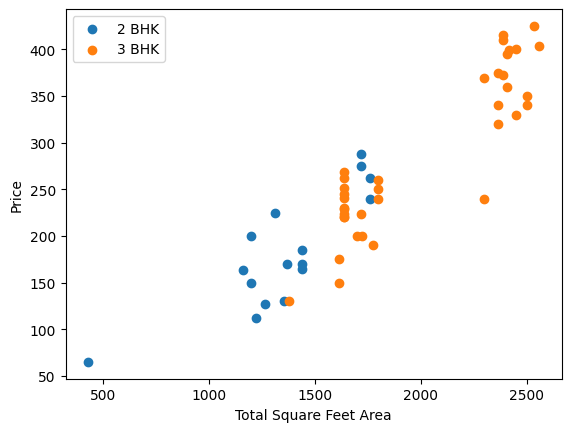

In [ ]:
plot_scatter_chart(df, "Rajaji Nagar")

Remove outliers in BHK column

In [ ]:
def remove_bhk_outliers(df):
    stats = df.groupBy("location", "BHK").agg(
        mean("price_per_sqft").alias("mean_pps"),
        stddev("price_per_sqft").alias("std_pps"),
        count("price_per_sqft").alias("count")
    )

    df_with_stats = df.join(stats, on=["location", "BHK"], how="left")

    df_cleaned = df_with_stats.filter(
        (col("price_per_sqft") >= col("mean_pps") - col("std_pps")) &
        (col("price_per_sqft") <= col("mean_pps") + col("std_pps"))
    )

    return df_cleaned.drop("mean_pps", "std_pps", "count")

df = remove_bhk_outliers(df)


Scatter plot after removing outliers

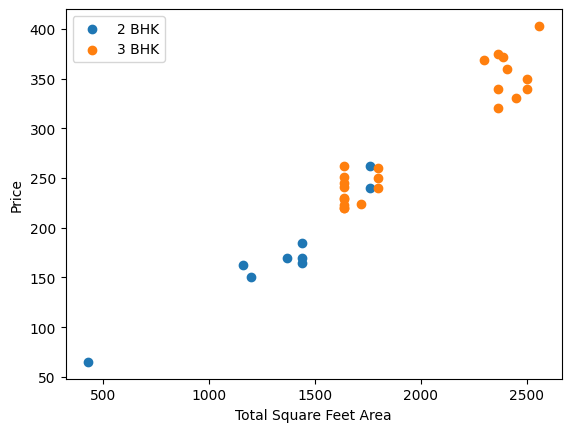

In [ ]:
plot_scatter_chart(df, "Rajaji Nagar")

Process location feature


In [ ]:
unique_locations_count = df.select("location").distinct().count()
print(f"Unique locations count: {unique_locations_count}")

Unique locations count: 601


In [ ]:
df = df.withColumn("location", F.trim(F.col("location")))

In [ ]:
location_stats = df.groupBy("location").agg(F.count("location").alias("count")) \
    .orderBy(F.desc("count"))
location_stats.show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|          Whitefield|  371|
|      Sarjapur  Road|  194|
|     Electronic City|  151|
|         Uttarahalli|  148|
|      Kanakpura Road|  128|
|           Yelahanka|  114|
|Raja Rajeshwari N...|  113|
|         Thanisandra|   95|
|        Marathahalli|   95|
|Electronic City P...|   91|
|              Hebbal|   88|
|        Haralur Road|   86|
|   Bannerghatta Road|   82|
|         Hennur Road|   78|
|  7th Phase JP Nagar|   70|
|          Chandapura|   65|
|          Begur Road|   57|
|        Yeshwanthpur|   54|
|            KR Puram|   49|
|            Sarjapur|   49|
+--------------------+-----+
only showing top 20 rows



In [ ]:
minor_locations = location_stats.filter(F.col("count") <= 10).select("location")
minor_locations_list = [row["location"] for row in minor_locations.collect()]
minor_locations.show()

+--------------------+
|            location|
+--------------------+
|          Anjanapura|
| Devarachikkanahalli|
|        Sonnenahalli|
|           Ardendale|
|          Rayasandra|
|          BTM Layout|
|       Kasturi Nagar|
|  6th Phase JP Nagar|
|               Begur|
|    Kereguddadahalli|
|         OMBR Layout|
|      Yelachenahalli|
|          Binny Pete|
|       Kenchenahalli|
|            Nagavara|
|       Murugeshpalya|
|         Mallasandra|
|  Basaveshwara Nagar|
|         Kaggalipura|
|Banashankari Stage V|
+--------------------+
only showing top 20 rows



In [ ]:
df = df.withColumn("location", F.when(F.col("location").isin(minor_locations_list), "other").otherwise(F.col("location")))

updated_unique_locations_count = df.select("location").distinct().count()
print(f"Updated unique locations count: {updated_unique_locations_count}")

Updated unique locations count: 149


In [ ]:
df = df.filter(F.col("location") != "other")

Process before training

In [ ]:
df = df.drop("size", "price_per_sqft")

indexer = StringIndexer(inputCol="location", outputCol="location_index")
encoder = OneHotEncoder(inputCol="location_index", outputCol="location_vec")

df = indexer.fit(df).transform(df)

df = encoder.fit(df).transform(df).drop("location", "location_index")

df.show()

+---+----------+----+-------+-----+-----------------+
|BHK|total_sqft|bath|balcony|price|     location_vec|
+---+----------+----+-------+-----+-----------------+
|  1|     435.0|   1|      1| 19.5|  (147,[2],[1.0])|
|  1|     550.0|   1|      1| 27.0|  (147,[2],[1.0])|
|  1|     440.0|   1|      0| 28.0| (147,[37],[1.0])|
|  1|     412.5|   1|      0| 19.8| (147,[37],[1.0])|
|  1|     510.0|   1|      0|25.25|  (147,[8],[1.0])|
|  1|     510.0|   1|      1|25.25|  (147,[8],[1.0])|
|  4|    2825.0|   4|      3|250.0|(147,[140],[1.0])|
|  3|    1875.0|   3|      1|167.0|(147,[140],[1.0])|
|  3|    2065.0|   4|      1|210.0|(147,[140],[1.0])|
|  2|    1394.0|   2|      1|100.0|(147,[140],[1.0])|
|  2|    1077.0|   2|      2| 93.0|(147,[140],[1.0])|
|  3|    2180.0|   3|      2|210.0|(147,[140],[1.0])|
|  2|    1180.0|   2|      2| 88.5|(147,[140],[1.0])|
|  3|    2077.0|   3|      3|175.0|(147,[140],[1.0])|
|  2|    1205.0|   2|      1| 85.0|(147,[140],[1.0])|
|  4|    2615.0|   5|      3

Filter out unrealistic data points by ensuring that the total square feet per BHK (bedroom) is at least 300 square feet

In [ ]:
df = df.filter((col("total_sqft") / col("BHK")) >= 300)

Filter out data points where the number of bathrooms exceeds the number of bedrooms (BHK) by 2 or more

In [ ]:
df = df.filter(col("bath") < col("BHK") + 2)

# 3. Model Development and Evaluation




In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Prepare the data for training and testing
# Combine features into a single vector column
data_assembler = VectorAssembler(inputCols=["BHK", "total_sqft", "bath", "balcony", "location_vec"], outputCol="features")
data = data_assembler.transform(df)
final_data = data.select("features", "price")

# Split the data into training (80%) and testing (20%) sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# 2. Initialize models
models = {
    "Linear Regression": LinearRegression(featuresCol="features", labelCol="price", maxIter=50, regParam=0.3, elasticNetParam=0.8),
    "Decision Tree": DecisionTreeRegressor(featuresCol="features", labelCol="price"),
    "Random Forest": RandomForestRegressor(featuresCol="features", labelCol="price"),
    "Gradient-Boosted Trees": GBTRegressor(featuresCol="features", labelCol="price")
}
trained_models = {}

# 3. Train and evaluate models
results = []
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")

for model_name, model in models.items():
    # Train the model
    trained_model = model.fit(train_data)
    trained_models[model_name] = trained_model

    # Make predictions on the test set
    predictions = trained_model.transform(test_data)

    # Evaluate metrics
    rmse = evaluator.setMetricName("rmse").evaluate(predictions)
    mse = evaluator.setMetricName("mse").evaluate(predictions)
    mae = evaluator.setMetricName("mae").evaluate(predictions)
    r2 = evaluator.setMetricName("r2").evaluate(predictions)

    # Store the results
    results.append({
        "Model": model_name,
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "R-squared": r2
    })

    # Print predictions for a quick check
    print(f"\n{model_name} Predictions:")
    predictions.select("features", "price", "prediction").show(5, truncate=False)

# 4. Compare results
print("\nModel Performance Comparison:")
for result in results:
    print(result)



Linear Regression Predictions:
+-----------------------------------------+-----+------------------+
|features                                 |price|prediction        |
+-----------------------------------------+-----+------------------+
|(151,[0,1,2,3],[2.0,1128.0,2.0,2.0])     |75.0 |54.01700714987362 |
|(151,[0,1,2,3],[2.0,1200.0,2.0,2.0])     |80.0 |59.48825938605026 |
|(151,[0,1,2,3],[2.0,1330.0,2.0,1.0])     |75.0 |70.61379104214642 |
|(151,[0,1,2,3,4],[1.0,605.0,1.0,1.0,1.0])|40.0 |25.714649087231663|
|(151,[0,1,2,3,4],[1.0,840.0,1.0,1.0,1.0])|57.6 |43.57220846919705 |
+-----------------------------------------+-----+------------------+
only showing top 5 rows


Decision Tree Predictions:
+-----------------------------------------+-----+------------------+
|features                                 |price|prediction        |
+-----------------------------------------+-----+------------------+
|(151,[0,1,2,3],[2.0,1128.0,2.0,2.0])     |75.0 |49.647654494382074|
|(151,[0,1,2,3],[2

# 6. Performance Optimization

In [ ]:
def evaluate_model(model, test_data):
  # Make predictions on the test set
  predictions = model.transform(test_data)

  # Evaluate metrics
  # Create a RegressionEvaluator
  evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")

  # Calculate metrics
  rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
  mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
  mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
  r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

  # Print the metrics
  print("Model Evaluation Metrics:")
  print("Root Mean Squared Error (RMSE):", rmse)
  print("Mean Squared Error (MSE):", mse)
  print("Mean Absolute Error (MAE):", mae)
  print("R-squared:", r2)

Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import random

# Define parameter ranges
param_ranges = {
    "regParam": [0.01, 0.1, 0.3, 0.5],
    "elasticNetParam": [0.0, 0.5, 1.0],
    "maxIter": [50, 100, 200]
}

# Generate random parameter samples
n_samples = 5
random_params = [{param: random.choice(values) for param, values in param_ranges.items()} for _ in range(n_samples)]

# Initialize evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# Perform random search
best_model = None
best_rmse = float("inf")
best_params = None

for params in random_params:
    # Create a new LinearRegression model with the sampled parameters
    lr = LinearRegression(
        featuresCol="features",
        labelCol="price",
        regParam=params["regParam"],
        elasticNetParam=params["elasticNetParam"],
        maxIter=params["maxIter"]
    )

    # Train the model
    model = lr.fit(train_data)
    predictions = model.transform(test_data)

    # Evaluate the model
    rmse = evaluator.evaluate(predictions)

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_params = params

# Display the best parameters and results
print(f"Linear Regression Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

Linear Regression Best Parameters: {'regParam': 0.1, 'elasticNetParam': 0.5, 'maxIter': 50}
Best RMSE: 18.192388222410965


Decision Tree

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

# Define parameter ranges
param_ranges = {
    "maxDepth": [5, 10, 15],
    "minInstancesPerNode": [1, 5, 10]
}

# Perform random search
best_model = None
best_rmse = float("inf")
best_params = None

for _ in range(n_samples):
    # Sample random parameters
    params = {param: random.choice(values) for param, values in param_ranges.items()}

    # Create a new DecisionTreeRegressor model with the sampled parameters
    dt = DecisionTreeRegressor(
        featuresCol="features",
        labelCol="price",
        maxDepth=params["maxDepth"],
        minInstancesPerNode=params["minInstancesPerNode"]
    )

    # Train the model
    model = dt.fit(train_data)
    predictions = model.transform(test_data)

    # Evaluate the model
    rmse = evaluator.evaluate(predictions)

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_params = params

# Display the best parameters and results
print(f"Decision Tree Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

Decision Tree Best Parameters: {'maxDepth': 15, 'minInstancesPerNode': 1}
Best RMSE: 23.53218297364502


Random Forest


In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# Define parameter ranges
param_ranges = {
    "numTrees": [20, 50, 100],
    "maxDepth": [5, 10, 15]
}

# Perform random search
best_model = None
best_rmse = float("inf")
best_params = None

for _ in range(n_samples):
    # Sample random parameters
    params = {param: random.choice(values) for param, values in param_ranges.items()}

    # Create a new RandomForestRegressor model with the sampled parameters
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="price",
        numTrees=params["numTrees"],
        maxDepth=params["maxDepth"]
    )

    # Train the model
    model = rf.fit(train_data)
    predictions = model.transform(test_data)

    # Evaluate the model
    rmse = evaluator.evaluate(predictions)

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_params = params

# Display the best parameters and results
print(f"Random Forest Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

Random Forest Best Parameters: {'numTrees': 100, 'maxDepth': 15}
Best RMSE: 21.21140833251626


Gradient - Boosted tree

In [ ]:
from pyspark.ml.regression import GBTRegressor

# Define parameter ranges
param_ranges = {
    "maxIter": [10, 20, 30],
    "maxDepth": [5, 10, 15]
}

# Perform random search
best_model = None
best_rmse = float("inf")
best_params = None

for _ in range(n_samples):
    # Sample random parameters
    params = {param: random.choice(values) for param, values in param_ranges.items()}

    # Create a new GBTRegressor model with the sampled parameters
    gbt = GBTRegressor(
        featuresCol="features",
        labelCol="price",
        maxIter=params["maxIter"],
        maxDepth=params["maxDepth"]
    )

    # Train the model
    model = gbt.fit(train_data)
    predictions = model.transform(test_data)

    # Evaluate the model
    rmse = evaluator.evaluate(predictions)

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_params = params

# Display the best parameters and results
print(f"Gradient-Boosted Trees Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

Gradient-Boosted Trees Best Parameters: {'maxIter': 30, 'maxDepth': 10}
Best RMSE: 20.66449802171988


# 5. Model Interpretation


### Linear Regression

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="price")

# Parameter Grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .addGrid(lr.regParam, [0.0, 0.1, 0.3]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross-Validation
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

lr_cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=2)  # 2-fold cross-validation

cvModel = lr_cv.fit(train_data)

In [ ]:
# Model Interpretation
bestModel = cvModel.bestModel
coefficients = bestModel.coefficients
intercept = bestModel.intercept

print("Coefficients: ", coefficients)
print("Intercept: ", intercept)

Coefficients:  [-4.257555345489827,0.0764112801426211,3.7445535281985567,-1.384423098796171,10.837835161775473,3.9577297774130282,-2.8873731633232564,-10.838814983417349,-0.23930463179102518,-4.118741023065459,-15.521773339211043,0.0,6.5004662188512,-19.743539626720278,24.73419259041376,-8.76437726634589,-4.0611399756333855,7.005369322905231,19.19511071268663,-13.706089709007903,-17.22837287371144,8.398704210376529,-10.180577965911027,-14.618583211790536,4.268942042679466,0.8756436195264531,0.0,180.17922550314094,-1.2173615306384833,0.0,8.64970655360623,-2.0847690201742086,-7.598966630138696,-4.18550073056724,2.5733450725736704,1.6533823705683732,16.213812622586982,-2.9212403894696206,6.048359391049867,-11.350600584255503,0.7043174963956154,0.0,-2.6034277492860074,-10.54497743182591,62.71860745913357,22.273022363042948,-5.746273236126066,-8.921495035365808,-4.0874598940161695,7.915451963375957,4.784920712924866,3.870997425072148,26.38892796310191,0.0,-4.8890625311183795,3.8119195170134

In [ ]:
trainingSummary = bestModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 21.076925
r2: 0.883737


In [ ]:
train_data.describe().show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|             3930|
|   mean|80.56175445292594|
| stddev|61.82177079613275|
|    min|             10.0|
|    max|            700.0|
+-------+-----------------+



* RMSE measures the differences between predicted values by the model and the actual values. However, RMSE alone is meaningless until we compare with the actual "price" value, such as mean, min and max. After such comparison, our RMSE looks pretty good.

* Since the RMSE of $21.2$ represents about $26.3\%$ of the mean, it indicates that the model is reasonably accurate in its predictions, especially in contexts where variability is expected.

* R squared at 0.88 indicates that in our model, approximate 88% of the variability in "price" can be explained using the model. This is not bad.

In [ ]:
data.show()

+---+----------+----+-------+-----+-----------------+--------------------+
|BHK|total_sqft|bath|balcony|price|     location_vec|            features|
+---+----------+----+-------+-----+-----------------+--------------------+
|  1|     435.0|   1|      1| 19.5|  (147,[2],[1.0])|(151,[0,1,2,3,6],...|
|  1|     550.0|   1|      1| 27.0|  (147,[2],[1.0])|(151,[0,1,2,3,6],...|
|  1|     440.0|   1|      0| 28.0| (147,[37],[1.0])|(151,[0,1,2,41],[...|
|  1|     412.5|   1|      0| 19.8| (147,[37],[1.0])|(151,[0,1,2,41],[...|
|  1|     510.0|   1|      0|25.25|  (147,[8],[1.0])|(151,[0,1,2,12],[...|
|  1|     510.0|   1|      1|25.25|  (147,[8],[1.0])|(151,[0,1,2,3,12]...|
|  4|    2825.0|   4|      3|250.0|(147,[140],[1.0])|(151,[0,1,2,3,144...|
|  3|    1875.0|   3|      1|167.0|(147,[140],[1.0])|(151,[0,1,2,3,144...|
|  3|    2065.0|   4|      1|210.0|(147,[140],[1.0])|(151,[0,1,2,3,144...|
|  2|    1394.0|   2|      1|100.0|(147,[140],[1.0])|(151,[0,1,2,3,144...|
|  2|    1077.0|   2|    

In [ ]:
feature_importance = sorted(list(zip(data.drop("price", "features").columns, map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

Feature Importance:
  location_vec: 10.838
  BHK: 4.258
  bath: 3.745
  balcony: 1.384
  total_sqft: 0.076


In [ ]:
bestModel.save("/content/drive/MyDrive/Colab Notebooks/Scalable & Distributed Computing/Project/LR")

In [ ]:
evaluate_model(bestModel, test_data)

Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 18.212896889138904
Mean Squared Error (MSE): 331.70961309440554
Mean Absolute Error (MAE): 10.076351029908635
R-squared: 0.883968765938489


### Decision Tree Regression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="price")

# Parameter Grid
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5]) \
    .addGrid(dt.minInstancesPerNode, [1, 2]) \
    .addGrid(dt.maxBins, [16]) \
    .build()

# Cross-Validation
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

dt_cv = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=2)  # 2-fold cross-validation

cvModel = dt_cv.fit(train_data)

In [ ]:
best_model = cvModel.bestModel

feature_importances = best_model.featureImportances
feature_names = data.drop("price", "features").columns

print("Feature Importances:")
for feature, importance in zip(feature_names, feature_importances):
    print(f"\t{feature}: {importance}")

Feature Importances:
	BHK: 0.03180481036605197
	total_sqft: 0.8461261411069382
	bath: 0.008869465084251835
	balcony: 3.405286568514633e-05
	location_vec: 0.02429266613741181


In [ ]:
best_model.save("/content/drive/MyDrive/Colab Notebooks/Scalable & Distributed Computing/Project/DTR")

In [ ]:
evaluate_model(best_model, test_data)

Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 28.57428724939395
Mean Squared Error (MSE): 816.4898918108778
Mean Absolute Error (MAE): 16.194545861915273
R-squared: 0.7143937769491084


### Random Forest Regression

In [ ]:
# Random Forest Model
rf = RandomForestRegressor(featuresCol="features", labelCol="price")

# Parameter Grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5, 10]) \
    .addGrid(rf.maxDepth, [3, 5]) \
    .addGrid(rf.minInstancesPerNode, [1, 2]) \
    .addGrid(rf.maxBins, [16]) \
    .build()

# Cross-Validation
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

rf_cv = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)

cvModel = rf_cv.fit(train_data)

In [ ]:
best_model = cvModel.bestModel

feature_importances = best_model.featureImportances
feature_names = data.drop("price", "features").columns

print("Feature Importances:")
for feature, importance in zip(feature_names, feature_importances):
    print(f"\t{feature}: {importance}")

Feature Importances:
	BHK: 0.05496151340174775
	total_sqft: 0.6354095350690507
	bath: 0.1792122365019562
	balcony: 0.021613627225728797
	location_vec: 0.022860115997690767


In [ ]:
best_model.save("/content/drive/MyDrive/Colab Notebooks/Scalable & Distributed Computing/Project/RFR")

In [ ]:
evaluate_model(best_model, test_data)

Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 27.781290579711403
Mean Squared Error (MSE): 771.8001062743615
Mean Absolute Error (MAE): 16.518222958496896
R-squared: 0.7300261576852991


### Gradient-Boosted Trees Regression

In [ ]:
# GBT Model
gbt = GBTRegressor(featuresCol="features", labelCol="price")

# Parameter Grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20])\
    .addGrid(gbt.maxDepth, [3, 5]) \
    .addGrid(gbt.minInstancesPerNode, [1]) \
    .addGrid(gbt.stepSize, [0.01, 0.1]) \
    .build()

# Cross-Validation
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

gbt_cv = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)

cvModel = gbt_cv.fit(train_data)

In [ ]:
best_model = cvModel.bestModel

feature_importances = best_model.featureImportances
feature_names = data.drop("price", "features").columns

print("Feature Importances:")
for feature, importance in zip(feature_names, feature_importances):
    print(f"\t{feature}: {importance}")

Feature Importances:
	BHK: 0.04623750637433625
	total_sqft: 0.5446281738423614
	bath: 0.027491018306691744
	balcony: 0.004739571627988223
	location_vec: 0.011104054516431879


In [ ]:
best_model.save("/content/drive/MyDrive/Colab Notebooks/Scalable & Distributed Computing/Project/GBTR")

In [ ]:
evaluate_model(best_model, test_data)

Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 22.596848829680834
Mean Squared Error (MSE): 510.61757703144804
Mean Absolute Error (MAE): 12.940398209118644
R-squared: 0.821387185485048
